# 05 SPDE on fenics

We consider the following stochastic Poisson problem on the square $\mathbf{x}=(x, y)\in\Omega := [0,
1]^2$:

$$
\label{eq:sPDE}
\begin{cases}
-\nabla\cdot (\kappa\ \nabla u)=1, & \mathbf{x} \in\Omega, \\
u = 0, & \mathbf{x}\in\partial\Omega_{\text{top}}\cup\partial\Omega_{\text{bottom}},\\
u = 10\ y\ (1-y), &\mathbf{x} \in\partial\Omega_{\text{left}}=\partial\Omega_{\text{inf}},\\
    \mathbf{n}\cdot\nabla u = 0, & \mathbf{x} \in\partial\Omega_{\text{right}}=\partial\Omega_{\text{out}},
\end{cases}
$$

with homegeneous Neumann boundary condition on the right side of the domain (outflow), that is $\partial\Omega_{\text{right}}$, Neumann boundary conditions on the left side of the domain (inflow), that is $\partial\Omega_{\text{left}}$, and Dirichlet boundary conditions on the remaining part of $\partial\Omega$.

The diffusion coefficient $\kappa:(\Omega, \mathcal{A}, P)\times\Omega\rightarrow \mathbb{R}$, where
$\mathcal{A}$ is a $\sigma$-algebra, is such that $\log(\kappa)$ is a Gaussian random field, with covariance function $C(\mathbf{x},\mathbf{y})$ defined by 
$$
C(\mathbf{x}, \mathbf{y}) = \exp\left(-\frac{\lVert \mathbf{x} - \mathbf{y} \rVert^{2}}{\beta^{2}}
\right),\quad \forall \mathbf{x},\mathbf{y}\in\Omega, 
$$
where $\beta=0.03$ is the correlation length. This random field is approximated with the truncated Karhunen–Loève decomposition
$$
\kappa(s, \mathbf{x}) \approx \exp\left(\sum_{i=0}^m X_i(s)
  \gamma_{i} \boldsymbol{\psi}_i (\mathbf{x}) \right)\qquad\forall (s,
\mathbf{x}) \in \Omega\times\Omega, 
$$
 where $(X_{i})_{i\in 1,\dots, m}$ are independent standard normal
 distributed random variables, and $(\gamma_{i},
 \boldsymbol{\psi}_{i})_{i\in 1,\dots, d}$ are the eigenpairs of the
 Karhunen–Loève decomposition of the zero-mean random field $\kappa$.

In our simulation the domain $\Omega$ is discretized with a triangular
unstructured mesh $\mathcal{T}$ with $3194$ triangles. The parameter
space has dimension $m=10$. The simulations are carried out with the finite
element method (FEM) with polynomial order one, and for each
simulation the parameters $(X_i)_{i=1,\dots m}$ are sampled from a
standard normal distribution. 

The solution $u$ is evaluated at
$d=1668$ degrees of freedom, thus $(V, R_{V})\approx(\mathbb{R}^{d},
S+M)$ where the metric $R_{V}$ is approximated with the sum of the
stiffness matrix $S\in\mathbb{R}^{d}\times\mathbb{R}^{d}$ and the
mass matrix $M\in\mathbb{R}^{d}\times\mathbb{R}^{d}$. This sum is a
discretization of the norm of the Sobolev space $H^{1}(\Omega)$. The number
of different independent simulations is $M=1000$. 

This test case was remodelled from [Zahm, Olivier, Paul G. Constantine, Clementine Prieur, and Youssef M. Marzouk. "Gradient-based dimension reduction of multivariate vector-valued functions."](https://epubs.siam.org/doi/pdf/10.1137/18M1221837).

Mind that running these simulations could take a lot of time, around 15 minutes on a laptop with a 6 cpu cores processor and 16 GB of RAM. All the additional .npy and .png files will be added in the subdirectory 05_SPDE.

In [11]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from pathlib import Path

In [12]:
def compute_mesh_map(mesh, dim):
  m_map = np.zeros((dim, 2))
  for j, cell in enumerate(cells(mesh)):
    m_map[j, :] = cell.midpoint().array()[:2]
  # print(m_map.shape)
  return m_map

def compute_cov(mesh, beta, dim, mesh_map):
  print("start covariance assemble")
  cov = np.zeros((dim, dim))
  for i in range(dim):
    for j in range(i, dim):
      cov[j, i] = cov[i, j] = np.exp(-(np.linalg.norm(mesh_map[i, :]-mesh_map[j, :], 1))/(beta))
      #cov[j, i] = cov[i, j] = np.exp(-(np.linalg.norm(mesh_map[i, :]-mesh_map[j, :]))**2/(beta)**2)
  print("end covariance assemble")
  evals, evecs = np.linalg.eig(cov)
  E = (evals[:m]*evecs[:, :m]).T
  return cov, E

def set_conductivity(sim_index, mesh, c):
  # print("set conductivity")
  D = FunctionSpace(mesh, "DG", 0)
  kappa = Function(D)
  dm = D.dofmap()
  for i, cell in enumerate(cells(mesh)):
    kappa.vector()[dm.cell_dofs(cell.index())] = np.exp(c[sim_index, i])
  return kappa

def boundary(x):
  return x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS

def boundary0(x):
  return  x[0] < DOLFIN_EPS  

def compute_solution(sim_index, mesh, kappa, pl=False):
  # print("compute solution")
  V = FunctionSpace(mesh, "Lagrange", 1)
  u0 = Expression("10*x[1]*(1-x[1])", degree=0)
  bc = DirichletBC(V, Constant(0.0), boundary)
  bc0 = DirichletBC(V, u0, boundary0)
  
  u = TrialFunction(V)
  v = TestFunction(V)
  f = Constant(1.0)#Expression("exp( - 2*pow(x[0]-0.5, 2) - 2*pow(x[1]-0.5, 2) )", element=V.ufl_element())
  a = kappa *inner(grad(u), grad(v))*dx
  L = f*v*dx
  u = Function(V)
  solve(a == L, u,[bc, bc0])

  if pl:
    u_pl = plot(u, title='u')
    plt.colorbar(u_pl)
    plt.show()
  return u 

def restrict(mesh, v):
  # print("restrict on outflow right side")
  Right = AutoSubDomain(lambda x, on_bnd: near(x[0], 1) and on_bnd)
  V = FunctionSpace(mesh, 'CG', 1)
  bc0 = DirichletBC(V, 1, Right)
  u = Function(V)
  bc0.apply(u.vector())
  v_restriction = v.vector()[u.vector() == 1]
  return v_restriction.mean()

def compute_gradients(component_index, mesh, kappa, E, boundary, cache, solution, pl=False):
  # print("compute gradient")
  V = FunctionSpace(mesh, "Lagrange", 1)
  bc = DirichletBC(V, Constant(0.0), boundary)
  w = TrialFunction(V)
  v = TestFunction(V)
  a = kappa*inner(grad(w), grad(v))*dx
  D = FunctionSpace(mesh, "DG", 0)

  dkappa = Function(D)
  dm = D.dofmap()
  for i, cell in enumerate(cells(mesh)):
    dkappa.vector()[dm.cell_dofs(cell.index())] = kappa.vector()[dm.cell_dofs(cell.index())]*E[component_index, i]
  rhs = dkappa * inner(grad(solution), grad(v))*dx

  w = Function(V)
  solve(a == rhs, w, bc)

  if pl:
    w_pl = plot(w, title='w')
    plt.colorbar(w_pl)
    plt.show()
  return w

def show_mode(mode, mesh):
  c = MeshFunction("double", mesh, 2)
  # value = mode.dot(E)

  # Iterate over mesh and set values
  for i, cell in enumerate(cells(mesh)):
    c[cell] = mode[i]#np.exp(value[i])
  
  plot(c)
  plt.show()

In [13]:
# Read mesh from file and create function space
mesh = Mesh("data/mesh.xml")

#dim = 6668 #mesh_2
dim = 3194
m = 10
M = 500
d = 1668
cache = np.zeros((d, m))
cache_res = np.zeros(m)

#choose lengthscale
beta = 0.015 #beta=0.03
inputs = np.random.multivariate_normal(np.zeros(m), np.eye(m), M)

#samples 
np.save("05_SPDE/inputs", inputs)

#covariance modes assemble
m_map = compute_mesh_map(mesh, dim)
cov, E = compute_cov(mesh, beta, dim, m_map)
c = inputs.dot(E)
np.save("05_SPDE/covariance", cov)
np.save("05_SPDE/cov_modes", E)

print("Karhunen-Loève mode shape", E.shape)

start covariance assemble
end covariance assemble
Karhunen-Loève mode shape (10, 3194)


Mode number 2 of Karhunen-Loève decomposition


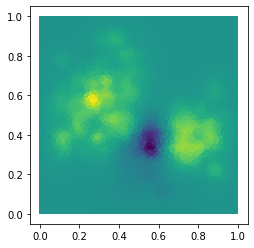

In [14]:
n = 2
print("Mode number {} of Karhunen-Loève decomposition".format(n))
show_mode(E[n, :], mesh)

In [15]:
# cov = np.load("data/covariance.npy", allow_pickle=True)
# E = np.load("data/cov_modes.npy", allow_pickle=True)

V = FunctionSpace(mesh, "Lagrange", 1)
dofs = V.dofmap().dofs()

# Get coordinates as len(dofs) x gdim array
dim =V.dim()
N = mesh.geometry().dim()
dofs_x = V.tabulate_dof_coordinates()
n_dof = 300
print("Coordinates of degree of freedom number {0} are {1}".format(n_dof, dofs_x[n_dof]))

Coordinates of degree of freedom number 300 are [0.27054928 0.42692123]


(1668,)


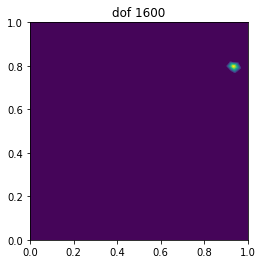

In [16]:
mesh = Mesh("data/mesh.xml")
V = FunctionSpace(mesh, "Lagrange", 1)
u = Function(V)
print(np.array(u.vector()[:]).shape)

for j in range(16):
    for i in range(1668):
        if i == (j+1)*100:
            u.vector()[i]= 1
        else:
            u.vector()[i]=0
    plot(u, title='dof {}'.format((1+j)*100))
    plt.savefig('05_SPDE/component_{}.png'.format((1+j)*100))

In [17]:
for it in range(M):
  print("Solution number :", it)
  #set conductivity
  kappa = set_conductivity(it, mesh, c)
  #plot(kappa)
  #plt.show()

  #compute solution
  u = compute_solution(it, mesh, kappa, pl=False)#pl=True to plot
  u_res = restrict(mesh, u)
  #print("mean of the solution restricted on the outflow (right side)", u_res)
  
  #compute gradients
  for j in range(m):
    #print("Evaluating gradient component number :", j)
    du = compute_gradients(j, mesh, kappa, E, boundary, cache, u)
    du_res = restrict(mesh, du)
    cache[:, j] = du.vector()[:]
    cache_res[j] = du_res

  file = Path("05_SPDE/outputs.npy")
  with file.open('ab') as f:
      np.save(f, u.vector()[:])
  
  file = Path("05_SPDE/outputs_res.npy")
  with file.open('ab') as f:
      np.save(f, u_res)

  file = Path("05_SPDE/gradients.npy")
  with file.open('ab') as f:
      np.save(f, cache)

  file = Path("05_SPDE/gradients_res.npy")
  with file.open('ab') as f:
      np.save(f, cache_res)

Solution number : 0
Solution number : 1
Solution number : 2
Solution number : 3
Solution number : 4
Solution number : 5
Solution number : 6
Solution number : 7
Solution number : 8
Solution number : 9
Solution number : 10
Solution number : 11
Solution number : 12
Solution number : 13
Solution number : 14
Solution number : 15
Solution number : 16
Solution number : 17
Solution number : 18
Solution number : 19
Solution number : 20
Solution number : 21
Solution number : 22
Solution number : 23
Solution number : 24
Solution number : 25
Solution number : 26
Solution number : 27
Solution number : 28
Solution number : 29
Solution number : 30
Solution number : 31
Solution number : 32
Solution number : 33
Solution number : 34
Solution number : 35
Solution number : 36
Solution number : 37
Solution number : 38
Solution number : 39
Solution number : 40
Solution number : 41
Solution number : 42
Solution number : 43
Solution number : 44
Solution number : 45
Solution number : 46
Solution number : 47
So

Solution number : 378
Solution number : 379
Solution number : 380
Solution number : 381
Solution number : 382
Solution number : 383
Solution number : 384
Solution number : 385
Solution number : 386
Solution number : 387
Solution number : 388
Solution number : 389
Solution number : 390
Solution number : 391
Solution number : 392
Solution number : 393
Solution number : 394
Solution number : 395
Solution number : 396
Solution number : 397
Solution number : 398
Solution number : 399
Solution number : 400
Solution number : 401
Solution number : 402
Solution number : 403
Solution number : 404
Solution number : 405
Solution number : 406
Solution number : 407
Solution number : 408
Solution number : 409
Solution number : 410
Solution number : 411
Solution number : 412
Solution number : 413
Solution number : 414
Solution number : 415
Solution number : 416
Solution number : 417
Solution number : 418
Solution number : 419
Solution number : 420
Solution number : 421
Solution number : 422
Solution n

### Remarks

Try different correlation coefficients beta=0.03, 0.04 and compare Karhunen-Loève modes with vectorial active subspaces modes in 05_SPDE_on_fenics_modes.ipynb
